In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ttbtestdataset/ttbtrain.csv
/kaggle/input/ttbtestdataset/ttbtest.csv


In [4]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # model split
import tensorflow as tf #tensorflow
from sklearn.feature_extraction.text import CountVectorizer #
from sklearn.feature_extraction.text import TfidfTransformer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder , LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , roc_auc_score , confusion_matrix , f1_score , recall_score , precision_score


In [5]:
"""
model2 = keras.Sequential([
    
    layers.Dense(1024,activation = 'relu',input_shape = [xtrain.shape[1]]),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1024,activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1024,activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1)
])
model2.compile(
    optimizer = 'adam' , 
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)
"""


"\nmodel2 = keras.Sequential([\n    \n    layers.Dense(1024,activation = 'relu',input_shape = [xtrain.shape[1]]),\n    layers.BatchNormalization(),\n    layers.Dropout(0.3),\n    layers.Dense(1024,activation = 'relu'),\n    layers.BatchNormalization(),\n    layers.Dropout(0.3),\n    layers.Dense(1024,activation = 'relu'),\n    layers.BatchNormalization(),\n    layers.Dropout(0.3),\n    layers.Dense(1)\n])\nmodel2.compile(\n    optimizer = 'adam' , \n    loss = keras.losses.BinaryCrossentropy(from_logits=True),\n    metrics=['accuracy']\n)\nearly_stopping = keras.callbacks.EarlyStopping(\n    patience=10,\n    min_delta=0.001,\n    restore_best_weights=True,\n)\n"

In [6]:
"""
history = model2.fit( xtrain , ytrain ,validation_data = (xtest, ytest) ,batch_size = 256 , epochs = 100 , verbose = 1, callbacks = early_stopping )
"""

'\nhistory = model2.fit( xtrain , ytrain ,validation_data = (xtest, ytest) ,batch_size = 256 , epochs = 100 , verbose = 1, callbacks = early_stopping )\n'

In [7]:
def printscore(yhat,y_test,name):
    display(pd.DataFrame(pd.Series({'roc_auc_score': str(roc_auc_score(yhat,y_test)),
'f1_score ':str(f1_score(yhat,y_test)),
'recall_score ':str(recall_score(yhat,y_test)),
'precision_score ':str(precision_score(yhat,y_test)),
'accuracy_score ':str(accuracy_score(yhat,y_test))})).rename(columns = {0 :name}))

In [8]:

def createbar(df,fea,re,Sort):
    sns.set_style("whitegrid", {'axes.grid' : False})
    fea_df = (pd.DataFrame(df.groupby(fea)[re].mean()))
    re_df = (pd.DataFrame(df.groupby(fea)[fea].count()/df.groupby(fea)[fea].count().sum()))
    sumdf = pd.concat([re_df,fea_df] , axis = 1)
    if(Sort == True):
        sumdf = sumdf.sort_values(by = re)
        
    col = [str(i)+'_dist' for i in sumdf.columns ]
    sumdf_re = sumdf.copy()
    sumdf_re.columns = col
    sumdf_re = sumdf_re.reset_index()
    
    fig,ax = plt.subplots(nrows = 1, figsize = (14,6),sharey = True)
    ax2 = ax.twinx()
    sumdf_re[fea] = sumdf_re[fea].astype('object')
    barplot = sns.barplot(data = sumdf_re*100 , x =  sumdf_re.index , y = str(fea)+'_dist',ax = ax,alpha = 0.8)
    lineplot = sns.lineplot(data = sumdf_re*100, x =  sumdf_re.index , y = str(re)+'_dist' ,ax = ax2, marker='o',\
                    markerfacecolor='red', markersize=6, color='orange', 
                    linewidth=2, label='% deposit Rate')
    for x,y in zip(sumdf_re.index, sumdf_re[(re+'_dist')]):
        
        label = "{:.2f}".format(y*100)
        lineplot.annotate(label, (x,y*100), textcoords="offset points", xytext=(0,5), ha='center', color='black') 
    barplot.set_title('distribution of '+fea+' vs '+re+'\n')
    barplot.set_xticklabels(sumdf_re[fea])
    barplot.set(ylabel = fea+'\n distribution'+'(%)')
    lineplot.set(ylabel = 'deposit Rate'+'(%)')
def findcolnum(df,droplist):
    if(len(droplist)>0):
        cat  = [i for i in df.drop(droplist,axis =1).columns if df[i].dtypes == 'object']
        num = [i for i in df.drop(droplist,axis =1).columns if df[i].dtypes != 'object']
    else:
        cat  = [i for i in df.columns if df[i].dtypes == 'object']
        num = [i for i in df.columns if df[i].dtypes != 'object']
        
    return (cat,num)
def createbin(df,fea,re,Sort):
    kk = df.copy()
    kk[fea+'bin'] = pd.cut(df[fea],5)
    createbar(kk,fea+'bin',re,Sort)
def createbincus(df,fea,re,Sort,num):
    kk = df.copy()
    kk[fea+'bin'] = pd.cut(df[fea],num)
    createbar(kk,fea+'bin',re,Sort)
def createbinq(df,fea,re,Sort):
    kk = df.copy()
    kk[fea+'bin'] = pd.qcut(df[fea],5)
    createbar(kk,fea+'bin',re,Sort)
def createbinqcus(df,fea,re,Sort,num):
    kk = df.copy()
    kk[fea+'bin'] = pd.qcut(df[fea],num)
    createbar(kk,fea+'bin',re,Sort)

In [9]:
def predictdf(y_pred,ytest,name):
    return pd.DataFrame(pd.Series({'roc_auc_score': str(roc_auc_score(y_pred,y_test)),
'f1_score ':str(f1_score(y_pred,y_test)),
'recall_score ':str(recall_score(y_pred,y_test)),
'precision_score ':str(precision_score(y_pred,y_test)),
'accuracy_score ':str(accuracy_score(y_pred,y_test))})).rename(columns = {0 :name})

In [10]:
def order_cluster(df, target_field_name, cluster_field_name, ascending):
    """
    INPUT:
        - df                  - pandas DataFrame
        - target_field_name   - str - A column in the pandas DataFrame df
        - cluster_field_name  - str - Expected to be a column in the pandas DataFrame df
        - ascending           - Boolean
        
    OUTPUT:
        - df_final            - pandas DataFrame with target_field_name and cluster_field_name as columns
    
    """
    # Add the string "new_" to cluster_field_name
    new_cluster_field_name = "new_" + cluster_field_name
    
    # Create a new dataframe by grouping the input dataframe by cluster_field_name and extract target_field_name 
    # and find the mean
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    
    # Sort the new dataframe df_new, by target_field_name in descending order
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    
    # Create a new column in df_new with column name index and assign it values to df_new.index
    df_new["index"] = df_new.index
    
    # Create a new dataframe by merging input dataframe df and part of the columns of df_new based on 
    # cluster_field_name
    df_final = pd.merge(df, df_new[[cluster_field_name, "index"]], on=cluster_field_name)
    
    # Update the dataframe df_final by deleting the column cluster_field_name
    df_final = df_final.drop([cluster_field_name], axis=1)
    
    # Rename the column index to cluster_field_name
    df_final = df_final.rename(columns={"index": cluster_field_name})
    
    return df_final


In [11]:
DATA = pd.read_csv('/kaggle/input/ttbtestdataset/ttbtrain.csv' , sep = ';')
DATA_train , DATA_test = train_test_split(DATA, test_size=0.33, random_state=42)
df = DATA.copy()

In [12]:
df.head()
df.shape

(45211, 17)

In [13]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [14]:
df['y'] = df.y.replace({"no":0 , 'yes':1})

# Data Understanding 

<AxesSubplot:ylabel='proportion of deposit'>

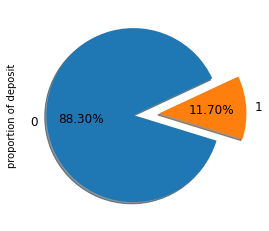

In [15]:
df["y"].value_counts().plot.pie(explode=[0,0.3], autopct='%1.2f%%',  shadow=True,label = 'proportion of deposit' ,
                                             fontsize=12, startangle=25)


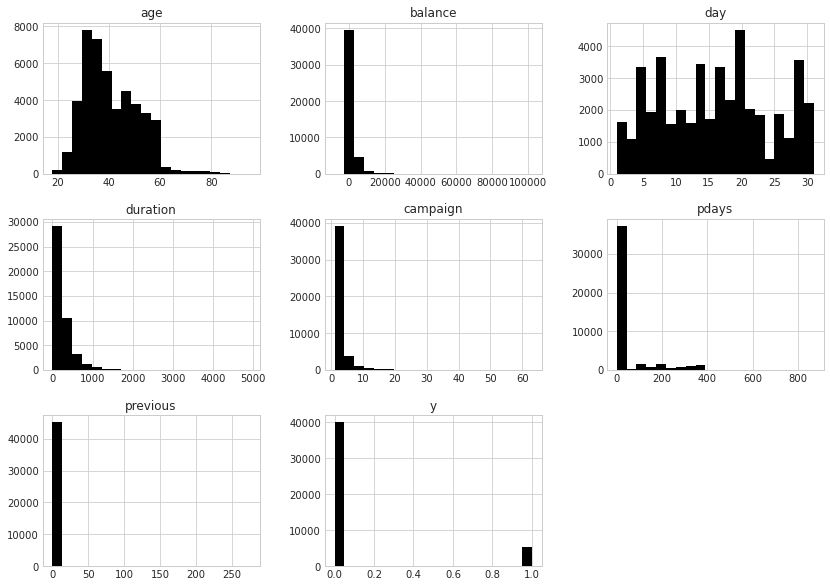

In [16]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

df.hist(bins=20, figsize=(14,10),color = 'black')
plt.show()

# EDA

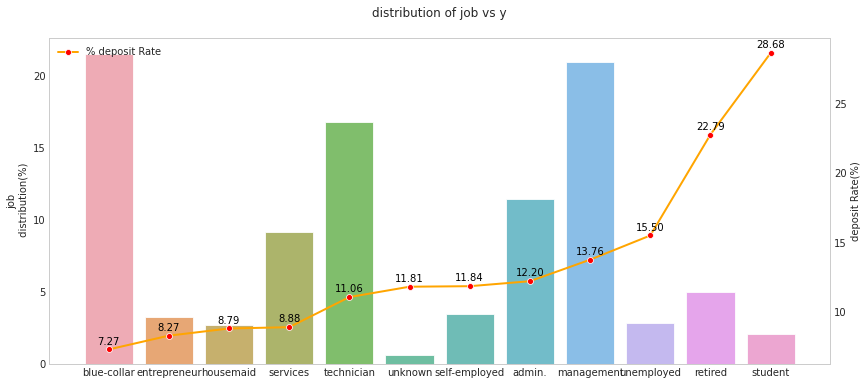

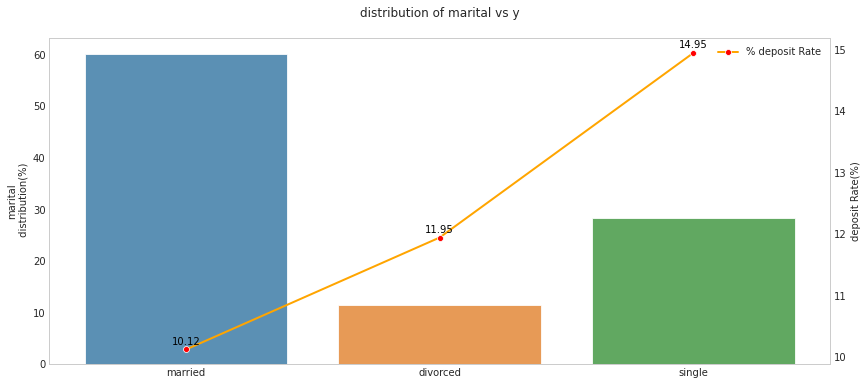

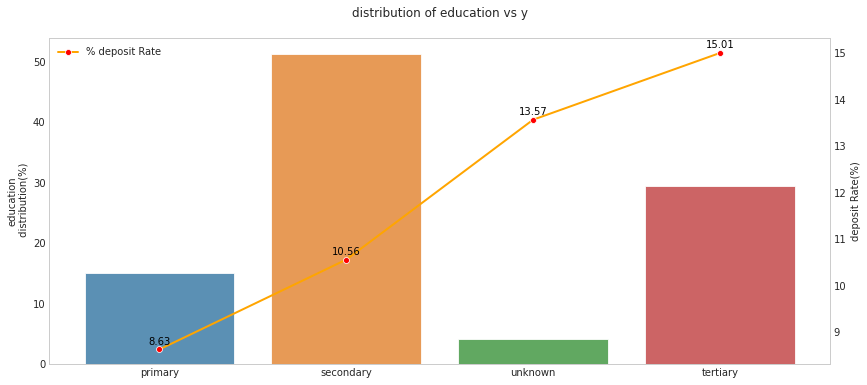

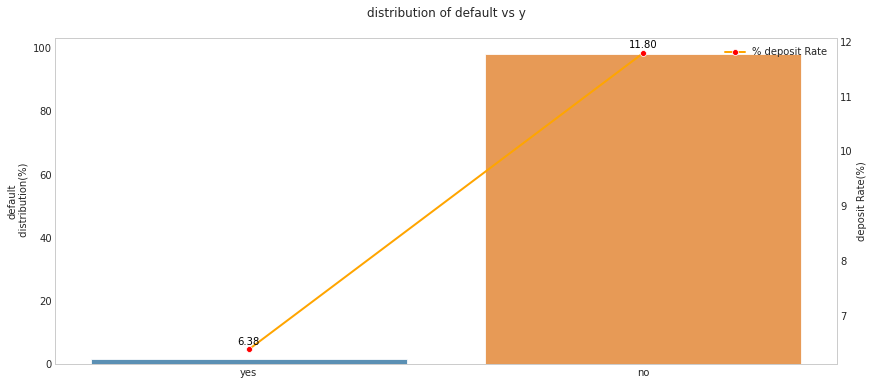

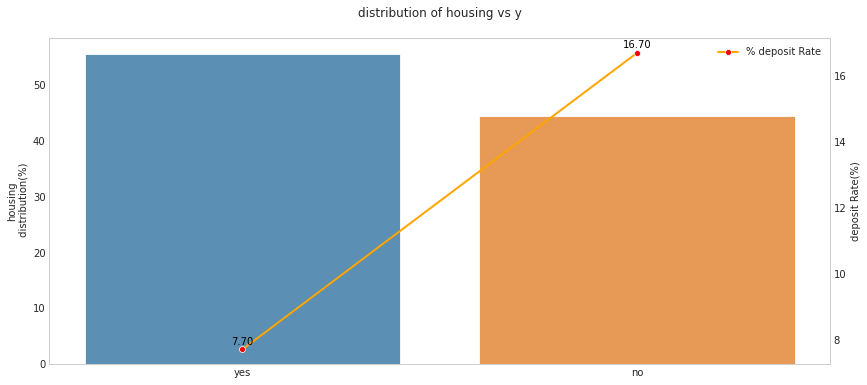

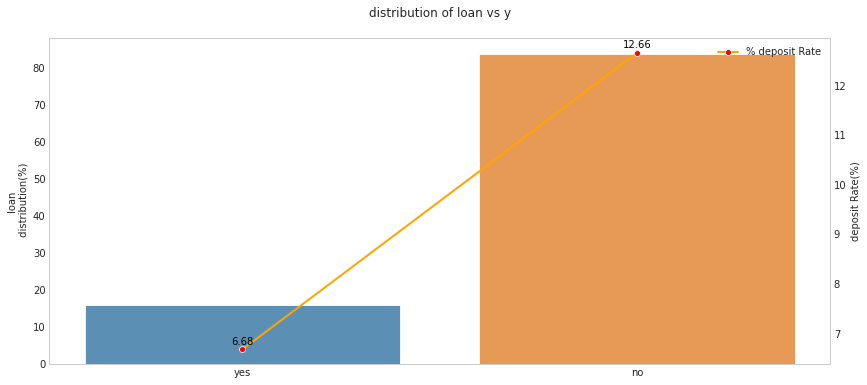

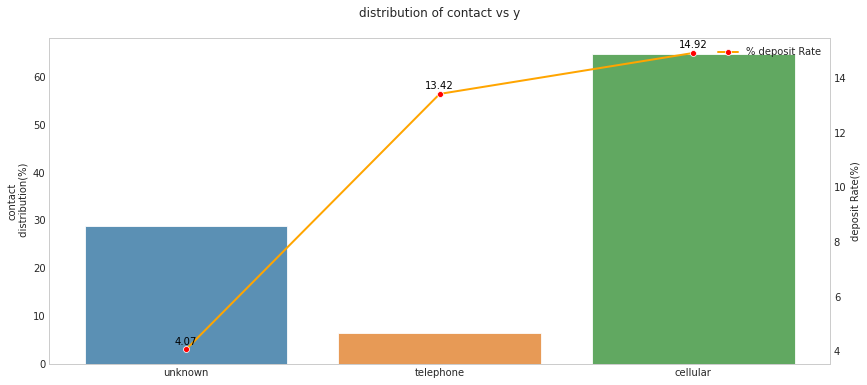

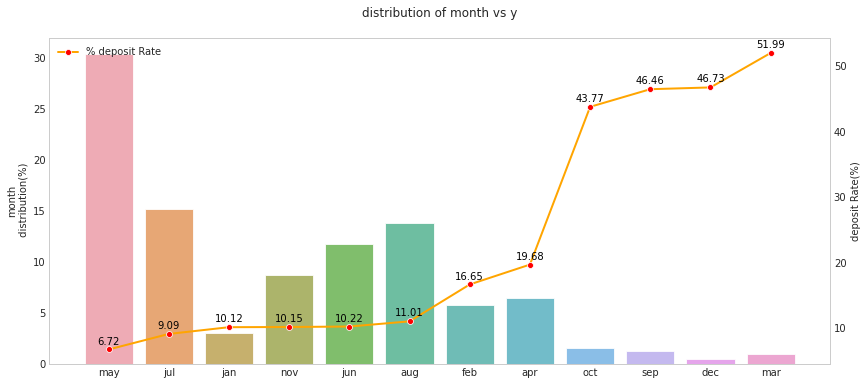

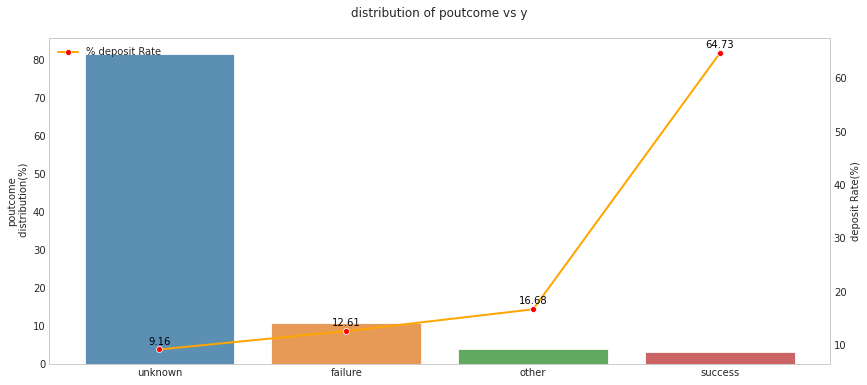

In [17]:
for i in findcolnum(df,'')[0]:
    createbar(df,i,'y',True)

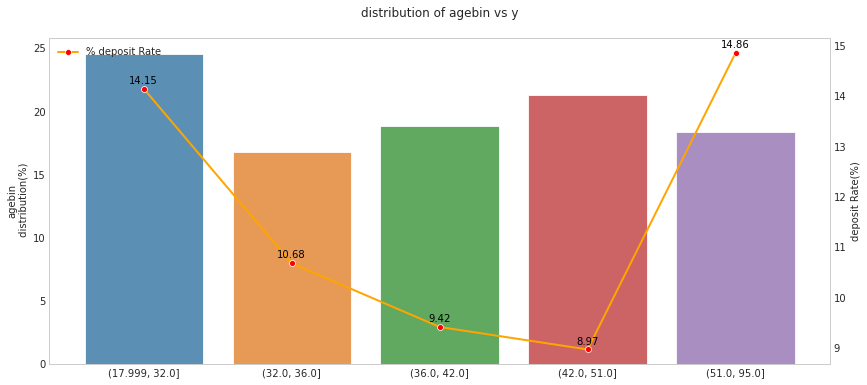

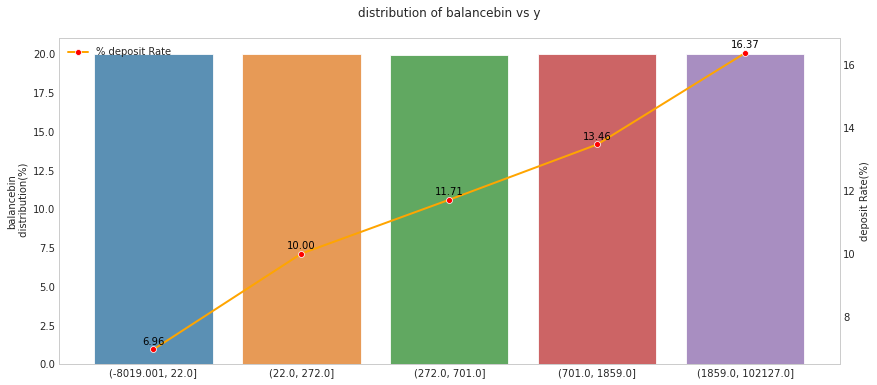

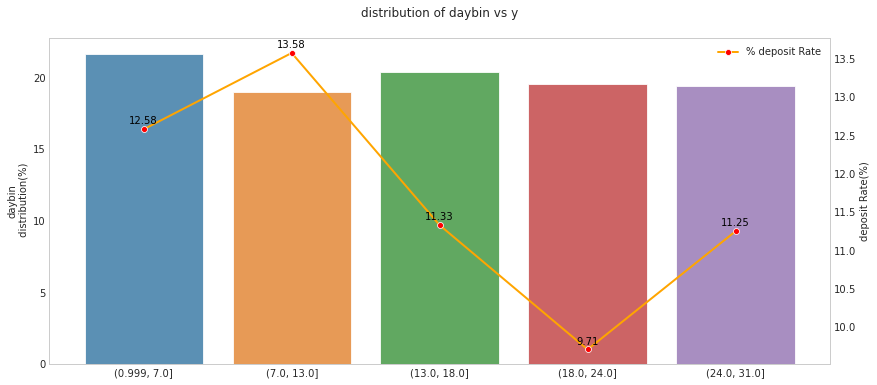

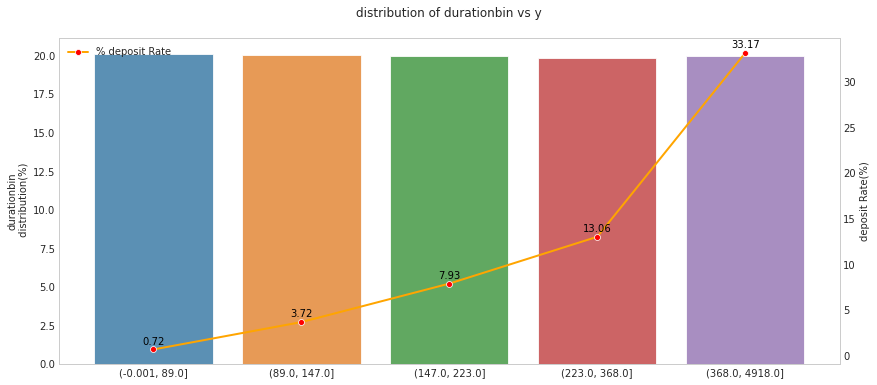

In [18]:
for i in findcolnum(df,['campaign', 'y' ,'pdays', 'previous'])[1]:
    createbinq(df,i,'y',False)

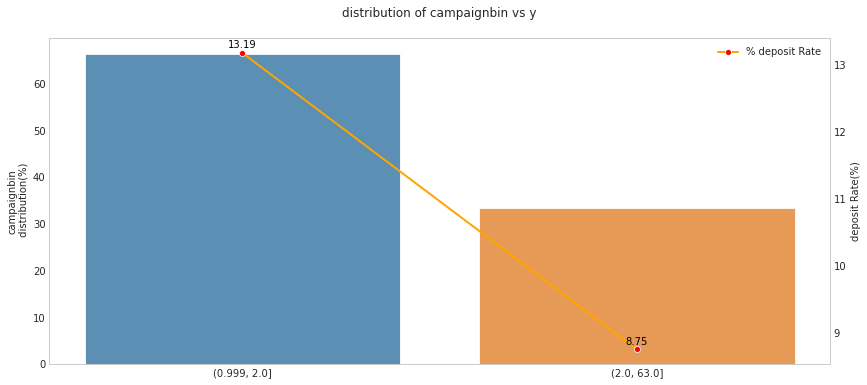

In [19]:
createbinqcus(df,'campaign','y',False,2)

<AxesSubplot:xlabel='pdays', ylabel='Count'>

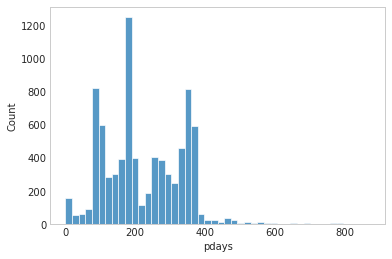

In [20]:
sns.histplot(data = df[df.pdays != -1] , x = 'pdays')

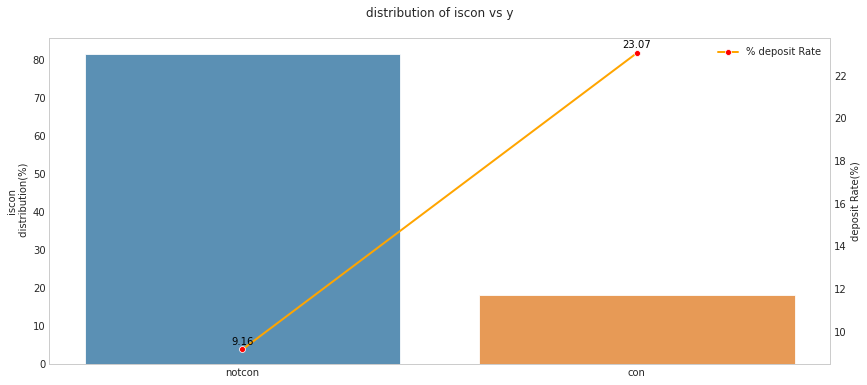

In [21]:
iscontact = df.copy()
iscontact['iscon'] = 'con'
iscontact.loc[iscontact['pdays'] == -1 , 'iscon'] = 'notcon'
createbar(iscontact ,'iscon' , 'y' ,True)

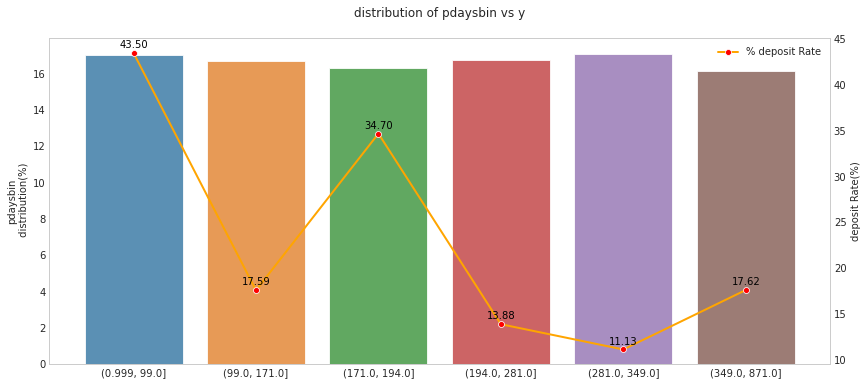

In [22]:
createbinqcus(df[(df.pdays != -1)],'pdays','y',False,6)

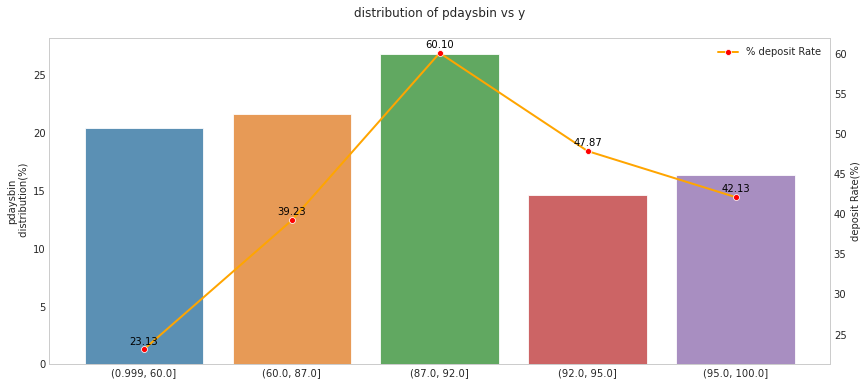

In [23]:
createbinqcus(df[(df.pdays != -1) & ((0 <= df.pdays) & (df.pdays <= 100) )],'pdays','y',False,5)

In [24]:
df[(df.month.isin(['oct','sep','dec','mar']))&(df.pdays != -1)].describe().T

,count,mean,std,min,25%,50%,75%,max
age,946.0,43.787526,14.993695,19.0,32.00,40.0,55.00,89.0
balance,946.0,2128.360465,4028.686126,-522.0,336.50,1026.0,2577.00,81204.0
day,946.0,14.543340,8.608272,1.0,7.25,14.0,22.00,31.0
duration,946.0,292.655391,239.905752,1.0,146.25,232.0,357.00,2062.0
campaign,946.0,1.835095,1.363265,1.0,1.00,1.0,2.00,13.0
pdays,946.0,197.485201,142.442118,15.0,99.00,182.0,202.75,854.0
previous,946.0,3.372093,3.388281,1.0,1.00,2.0,4.00,41.0
y,946.0,0.514799,0.500045,0.0,0.00,1.0,1.00,1.0


<AxesSubplot:xlabel='previous', ylabel='Count'>

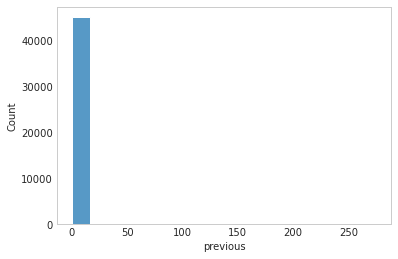

In [25]:
sns.histplot(data = df , x = 'previous')


<AxesSubplot:xlabel='previous', ylabel='Count'>

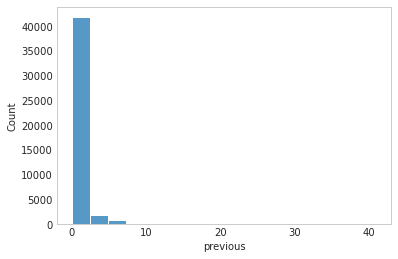

In [26]:
sns.histplot(data = df[df.previous <50] , x = 'previous')

<AxesSubplot:xlabel='previous', ylabel='Count'>

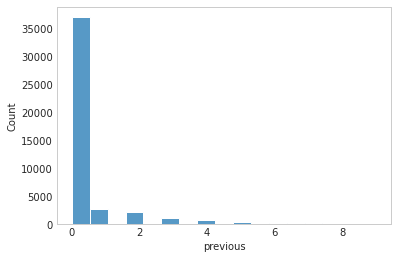

In [27]:
sns.histplot(data = df[df.previous <10] , x = 'previous')

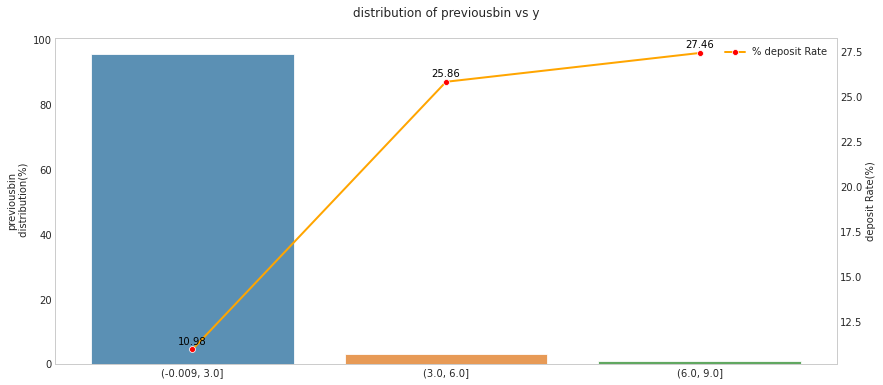

In [28]:
createbincus(df[df.previous <10],'previous','y',False,3)

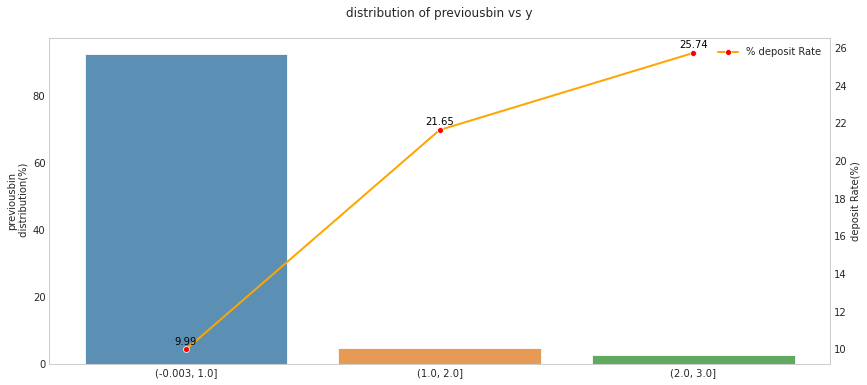

In [29]:
createbincus(df[df.previous <=3],'previous','y',False,3)

<AxesSubplot:>

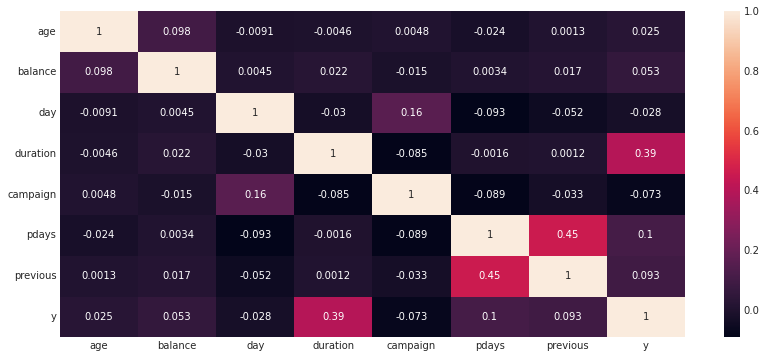

In [30]:
plt.figure(figsize = (14,6))
sns.heatmap(df.corr(),annot = True
           )

# Feature engineering 

In [31]:
data = df.copy()

In [32]:
data = data.replace({'yes':1 , 'no' : 0})
data['housing_loan'] = data['housing'] | data['loan']

**job/marital/education**

In [33]:
data.groupby('job')[['balance']].mean().sort_values(by = 'balance' , ascending = False)

,balance
job,
retired,1984.215106
unknown,1772.357639
management,1763.616832
self-employed,1647.970868
unemployed,1521.745971
entrepreneur,1521.470074
housemaid,1392.395161
student,1388.060768
technician,1252.632092


<AxesSubplot:xlabel='deposit_rate', ylabel='job/mar'>

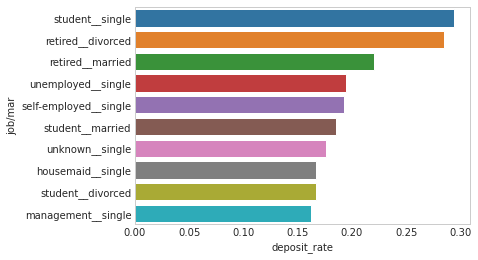

In [34]:
jobmar = data.groupby(['job','marital'])[['balance','y','age','housing_loan']].mean().reset_index().rename(columns = {'y':'deposit_rate'})
jobmar['por'] = jobmar['balance']/jobmar.housing_loan
jobmar['job'] =data.groupby(['job','marital'])[['balance','y','age','housing_loan']].mean().rename(columns = {'y':'deposit_rate'}).reset_index()['job'] 
jobmar['marital'] =data.groupby(['job','marital'])[['balance','y','age','housing_loan']].mean().rename(columns = {'y':'deposit_rate'}).reset_index()['marital']
jobmar['job/mar'] = jobmar['job'] +'__'+jobmar['marital']
#display(jobmar)
sns.barplot(data = jobmar.sort_values(by = 'deposit_rate' ,ascending = False)[:10] , y = 'job/mar' ,x = 'deposit_rate')

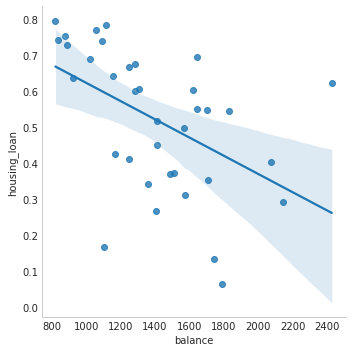

In [35]:
sns.lmplot(data = jobmar , x = 'balance' , y = 'housing_loan')

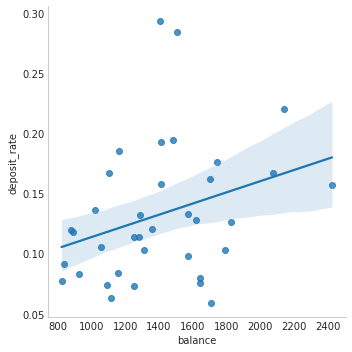

In [36]:
sns.lmplot(data = jobmar , x='balance' ,y = 'deposit_rate' )

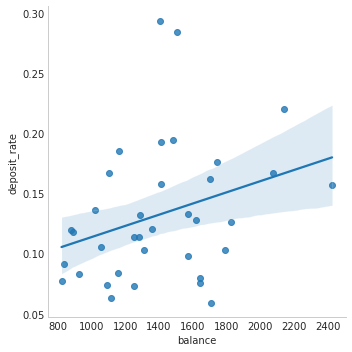

In [37]:
sns.lmplot(data = jobmar , x='balance' ,y = 'deposit_rate' )

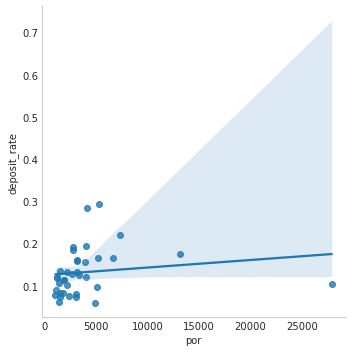

In [38]:
sns.lmplot(data = jobmar , x = 'por' , y = 'deposit_rate')

In [39]:
data.groupby('education').housing_loan.mean()

education
primary      0.633192
secondary    0.676062
tertiary     0.534095
unknown      0.473344
Name: housing_loan, dtype: float64

education is not important , job and marital are more important

In [40]:
d = {}
def porapply(row):
    d[(row.job , row.marital)] = row.por
jobmar.apply(porapply , axis = 1)
print(d)
def pordata(row):
    row['por'] = d[(row.job , row.marital)]
    return row
data = data.apply(pordata , axis = 1)

{('admin.', 'divorced'): 1167.9964539007092, ('admin.', 'married'): 1901.287052341598, ('admin.', 'single'): 1482.2159663865546, ('blue-collar', 'divorced'): 1031.1641541038525, ('blue-collar', 'married'): 1422.174550788412, ('blue-collar', 'single'): 1374.0284237726098, ('entrepreneur', 'divorced'): 1799.3130434782609, ('entrepreneur', 'married'): 2369.845013477089, ('entrepreneur', 'single'): 1868.427672955975, ('housemaid', 'divorced'): 5078.473684210527, ('housemaid', 'married'): 3035.5573333333336, ('housemaid', 'single'): 5151.086206896552, ('management', 'divorced'): 2683.1044776119406, ('management', 'married'): 3355.5611828687965, ('management', 'single'): 3106.35275883447, ('retired', 'divorced'): 4055.886075949367, ('retired', 'married'): 7350.2202380952385, ('retired', 'single'): 3970.8648648648646, ('self-employed', 'divorced'): 3904.471264367816, ('self-employed', 'married'): 2986.168190127971, ('self-employed', 'single'): 2734.882608695652, ('services', 'divorced'): 1122

<AxesSubplot:>

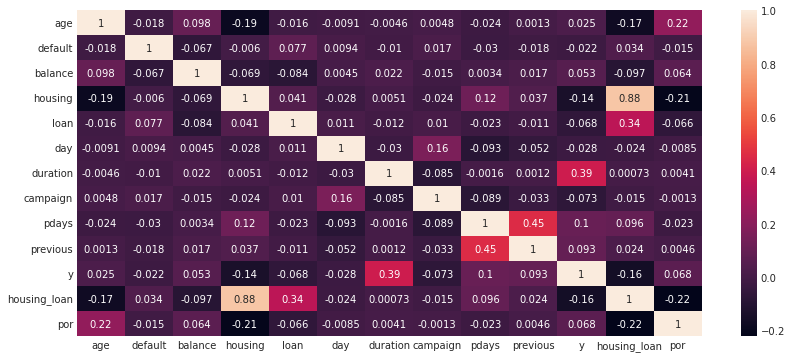

In [41]:
plt.figure(figsize = (14,6))
sns.heatmap(data.corr(),annot = True)

**Campaign / pdays / previous**|

In [42]:
iscontact = df.copy()
iscontact['iscon'] = 1
iscontact.loc[iscontact['pdays'] == -1 , 'iscon'] = 0
#createbar(iscontact ,'iscon' , 'y' ,True)
data['iscon'] = iscontact['iscon']

In [43]:
data['pdaysbin'] = 0
data.loc[(data.iscon == 1) & (data.pdays >= 80 )  &(data.pdays <100)|(data.pdays >= 170) &(data.pdays <200),'pdaysbin'] = 1

In [44]:
data['campaign_bin'] = 0
data.loc[df.campaign <= 2,'campaign_bin'] = 1

<AxesSubplot:>

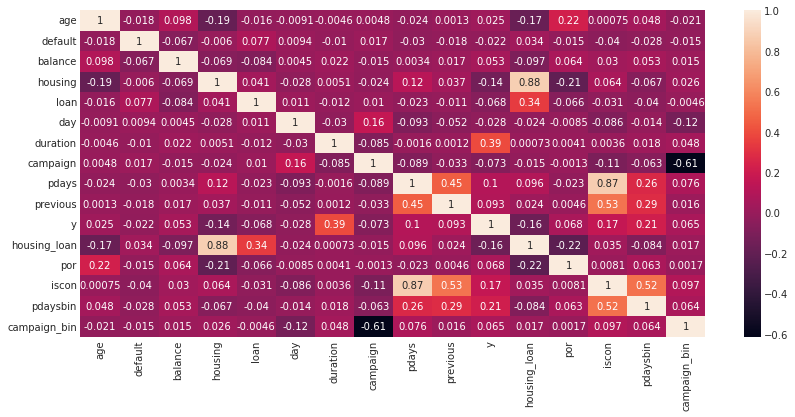

In [45]:
plt.figure(figsize = (14,6))
sns.heatmap(data.corr(),annot = True)

**Age**

In [46]:
data['age_bin'] = 0
data.loc[(df.age <= 30) |(df.age >=60),'age_bin'] = 1


In [47]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,pdays,previous,poutcome,y,housing_loan,por,iscon,pdaysbin,campaign_bin,age_bin
0,58,management,married,tertiary,0,2143,1,0,unknown,5,...,-1,0,unknown,0,1,3355.561183,0,0,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,...,-1,0,unknown,0,1,2141.259071,0,0,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,...,-1,0,unknown,0,1,2369.845013,0,0,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,...,-1,0,unknown,0,1,1422.174551,0,0,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,...,-1,0,unknown,0,0,13160.222222,0,0,1,0


# Modeling

In [48]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'housing_loan', 'por', 'iscon', 'pdaysbin',
       'campaign_bin', 'age_bin'],
      dtype='object')

<AxesSubplot:>

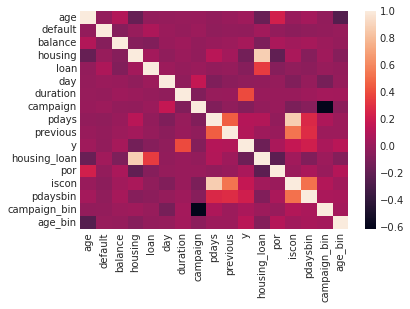

In [49]:
sns.heatmap(data.corr())

In [50]:
bftrain = pd.get_dummies(data.drop(['duration','month'],axis = 1))

In [51]:
xtrain,xtest,ytrain,ytest = train_test_split(bftrain.drop('y',axis = 1),bftrain.y,test_size = 0.33 , random_state = 42 )

In [52]:
import xgboost
xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(xtrain,ytrain.squeeze().values)
printscore(xgb.predict(xtrain),ytrain,'train')
printscore(xgb.predict(xtest),ytest,'test')
#calculate and print scores for the model for top 15 features
y_train_preds = xgb.predict(xtrain)
y_test_preds = xgb.predict(xtest)

print('XGB accuracy score for train: %.3f: test: %.3f' % (
        accuracy_score(ytrain, y_train_preds),
        accuracy_score(ytest, y_test_preds)))

,train
roc_auc_score,0.8959646579792698
f1_score,0.41167567567567576
recall_score,0.8806660499537465
precision_score,0.2686230248306998
accuracy_score,0.9101713380211944


,test
roc_auc_score,0.7725313260691515
f1_score,0.2854594112399643
recall_score,0.6438631790744467
precision_score,0.1833810888252149
accuracy_score,0.892627345844504


XGB accuracy score for train: 0.910: test: 0.893


In [53]:
model2 = RandomForestClassifier(random_state = 1)
model2.fit(xtrain,ytrain)
printscore(model2.predict(xtest),ytest,'dt')

,dt
roc_auc_score,0.7497201357971264
f1_score,0.29190125595495886
recall_score,0.5975177304964538
precision_score,0.19312320916905446
accuracy_score,0.8904155495978552


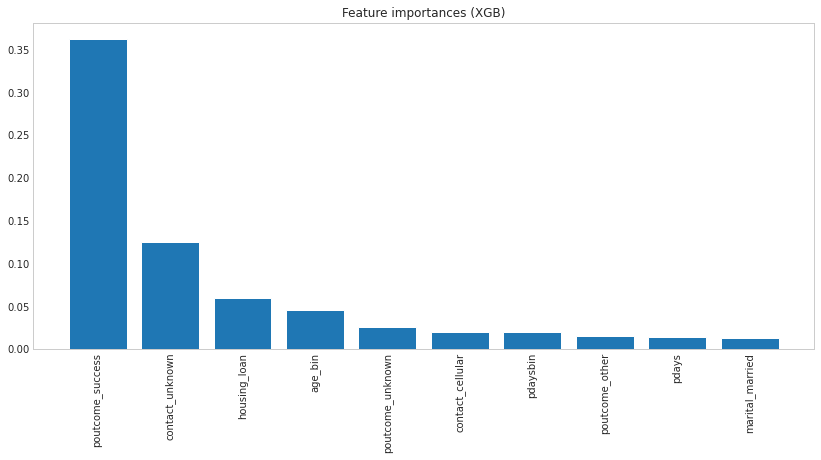

In [54]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(xtrain.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

#plot feature importances
x_pos = np.arange(0, len(xgb_feature_importances))
plt.figure(figsize = (14,6))
plt.bar(x_pos[:10], xgb_feature_importances[:10]['score'])
plt.xticks(x_pos[:10], xgb_feature_importances[:10]['name'])
plt.xticks(rotation=90)
plt.title('Feature importances (XGB)')

plt.show()